In [56]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
)


In [57]:
syn = pd.read_csv("synthetic_data.csv")
syn.head()


,Unnamed: 0,Label,News Headlines
0,0,0,in litterature tsunami as raised million milit...
1,1,0,nine dead hernndez fought country national mus...
2,2,0,it criticised student protestors fronts russia...
3,3,0,royalties and in her for ddos the presidential...
4,4,0,cbc pope hunt on was killed hastily built can ...


In [58]:
start_time = time.time()


In [59]:
x, y = syn["News Headlines"].values, syn["Label"].values


x_train, x_test, y_train, y_test = train_test_split(
    syn["News Headlines"], syn.Label, test_size=0.2, random_state=42
)


In [60]:
train_x_values = x_train.values
# set the max of features to 4000
features = 4000
tok = Tokenizer(num_words=features)
tok.fit_on_texts(train_x_values)
size = len(tok.word_index) + 1


In [61]:
encoded = tok.texts_to_sequences(train_x_values)
padded = pad_sequences(encoded, maxlen=10)


In [62]:
# The document is padded with the maximum lenth of 10
max_len = 10
model = Sequential()
model.add(Embedding(size, 128, input_length=max_len))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, recurrent_dropout=0.3, dropout=0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 128)           3727360   
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 10, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,859,073
Trainable params: 3,859,073
Non-trainable params: 0
_________________________________________________________________


In [63]:
result = model.fit(padded, y_train, batch_size=32, validation_split=0.2, epochs=10)


Epoch 1/10


/Users/jennyshen/opt/miniconda3/lib/python3.10/site-packages/keras/engine/data_adapter.py:1508: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


40/40 [==============================] - 2s 26ms/step - loss: 0.6941 - accuracy: 0.4756 - val_loss: 0.6949 - val_accuracy: 0.4654
Epoch 2/10
40/40 [==============================] - 1s 25ms/step - loss: 0.6435 - accuracy: 0.6305 - val_loss: 0.7400 - val_accuracy: 0.5597
Epoch 3/10
40/40 [==============================] - 1s 25ms/step - loss: 0.4152 - accuracy: 0.8318 - val_loss: 0.9468 - val_accuracy: 0.4906
Epoch 4/10
40/40 [==============================] - 1s 25ms/step - loss: 0.2253 - accuracy: 0.9143 - val_loss: 1.0430 - val_accuracy: 0.5314
Epoch 5/10
40/40 [==============================] - 1s 25ms/step - loss: 0.1059 - accuracy: 0.9638 - val_loss: 1.5752 - val_accuracy: 0.4969
Epoch 6/10
40/40 [==============================] - 1s 25ms/step - loss: 0.0534 - accuracy: 0.9835 - val_loss: 1.9221 - val_accuracy: 0.5094
Epoch 7/10
40/40 [==============================] - 1s 25ms/step - loss: 0.0348 - accuracy: 0.9890 - val_loss: 1.8975 - val_accuracy: 0.5094
Epoch 8/10
40/40 [======

In [64]:
end_time = time.time() - start_time
print("Training time: {:.2f} s".format(end_time))


Training time: 12.17 s


In [65]:
predicted = tok.texts_to_sequences(x_test.values)
predicted = pad_sequences(predicted, maxlen=10)
predicted = model.predict(predicted).round()

# get the roc_auc_score for model
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predicted)


13/13 [==============================] - 0s 3ms/step


0.5167273094804932

In [66]:
accuracy_score(y_test, predicted)


0.5150753768844221

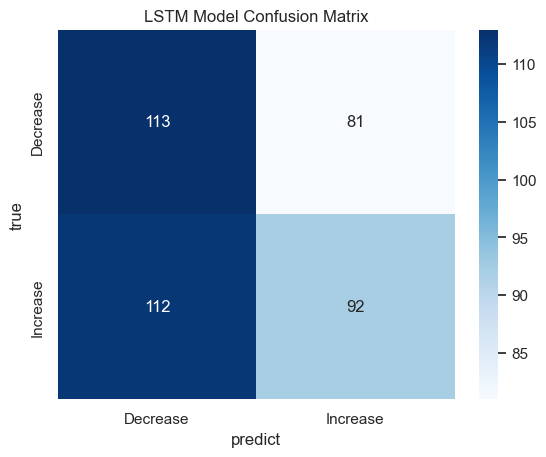

In [67]:
matrix = confusion_matrix(y_test, predicted)

# Plot the confusion matrix heatmap
import seaborn as sns

sns.set()
confusion_matrix_name = pd.DataFrame(
    matrix, index=["Decrease", "Increase"], columns=["Decrease", "Increase"]
)
f, ax = plt.subplots()
sns.heatmap(confusion_matrix_name, annot=True, fmt=".20g", cmap=plt.cm.Blues, ax=ax)

ax.set_title("LSTM Model Confusion Matrix")
ax.set_xlabel("predict")
ax.set_ylabel("true")
# plt.savefig("LSTM_synthetic_confusion_matrix.png")


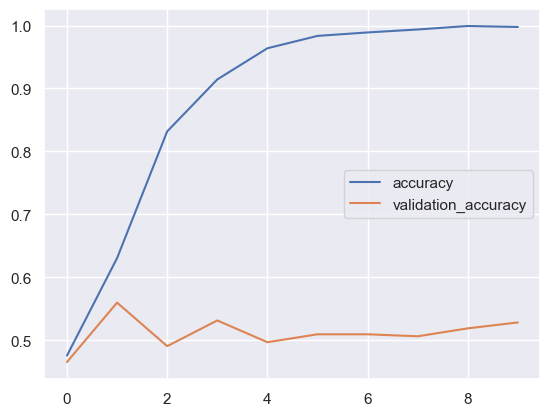

In [68]:
plt.plot(result.history["accuracy"], label="accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend()
plt.show()


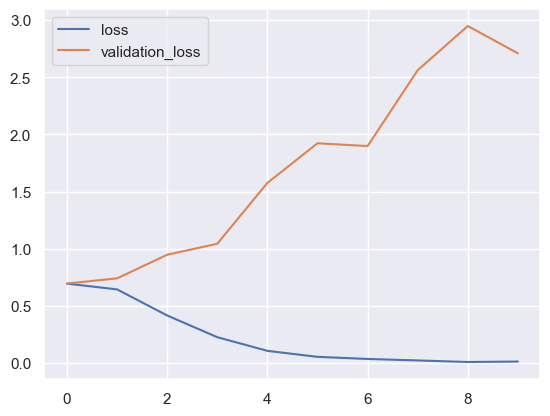

In [69]:
plt.plot(result.history["loss"], label="loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend()
plt.show()
